# Ball-sphere image processing
Given photos of the ball, extract spherical pathes on the same position of the photo, then stitch into 1 image

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

### Read and Plot by cv2
refer to the Link-course "OpenCV Python Developers"

(5464, 8192, 3) 134283264


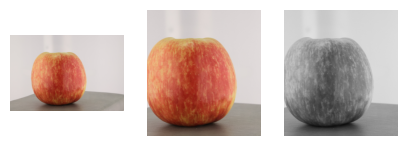

In [142]:
## read photo
paths = ['./photos_ball', './photos_drill', './photos_apple', './photos_cup']
path = paths[2] ### need to choose the path name

names = [file for file in glob.glob(path+"/*.jpg")]
name = names[5]

img = cv2.imread(name,1)
print(img.shape, img.size)

## change jpg to png
# cv2.imwrite(path + "\\1.png", img)
# img = cv2.imread(path+'\\1.png',1)

## rescale the photo
img = cv2.resize(img, (0,0), fx=0.1, fy=0.1)

## crop the photo
num_row, num_col = img.shape[0], img.shape[1]
subimg = img[:, int(num_col*0.2):int(num_col*0.8), :]

## convert it to a grayscale image
gray_img = cv2.cvtColor(subimg, cv2.COLOR_BGR2GRAY)

if 0:
    cv2.imshow("Sub-image", subimg)
    cv2.waitKey()
    cv2.destroyAllWindows()
elif 1:
    fig, axs = plt.subplots(1,3,figsize=(5,5))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].imshow(cv2.cvtColor(subimg, cv2.COLOR_BGR2RGB))
    axs[2].imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    axs[2].set_axis_off()
    plt.show()

## Ways to get bounding circle contour
1. circle_canny: used for photos_ball. Need relatively good / stable positions of the object in the photos.
2. circle_Hough: cv2.HoughCircles() to detect circle
3. circle_contour: cv2.findContours
4. circle_moment: cv2.moments
5. circle_blob: cv2.SimpleBlobDetector, cv2.SimpleBlobDetector_create, suitable for multi-small circles
6. circle_match: cv2.matchTemplate for stitching

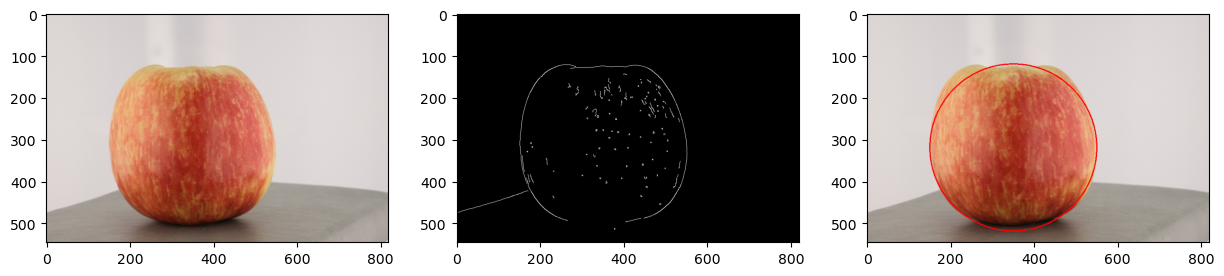

((350, 319), 200)

In [132]:
def circle_canny(img, is_crop=False, is_scale=False, is_RGB=False):
    """Use the Canny edge detection algorithm to detect edges in the image,
    then search for the left boundary-edge and right boundary-edge to rebuld the circle
    """
    #img = cv2.imread(name)

    if is_crop:
        num_row, num_col = img.shape[0], img.shape[1]
        img = img[:, int(num_col*0.2):int(num_col*0.8), :]

    if is_scale:
        # Define the scale percentage for resizing the image
        scale_percent = 15.625  # 100% means keeping the original size, you can change this value
        width = int(img.shape[1] * scale_percent / 100)  # Calculate the new width
        height = int(img.shape[0] * scale_percent / 100)  # Calculate the new height
        dim = (width, height)  # Create a tuple representing the new dimensions (width, height)

        # Resize the image using the calculated dimensions and interpolation method (INTER_AREA)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA) ##is around (853, 1280)
    
    if is_RGB:
        # used for plt.imshow, otherwise cv2.imshow will turn to blue. Work inversely.
        # Convert the color channels from RGB to BGR format (OpenCV uses BGR by default)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # plt.imshow(img)

    # Canny Parameters:
    #   img: The input image on which edge detection will be performed.
    #   40: The lower threshold value. This value determines the intensity gradient below which edges are not considered.
    #   180: The upper threshold value. This value determines the intensity gradient above which edges are considered strong edges.
    #   apertureSize: The size of the Sobel kernel used for edge detection. It can be 3, 5, or 7. A larger value gives smoother edges.
    #   L2gradient: A Boolean flag to specify the gradient magnitude calculation method. If True, L2 norm (Euclidean distance) is used. If False, L1 norm (Manhattan distance) is used.
    # (40,180) is suitable for the image size around (853, 1280)
    # for drillbit, the number maybe (100, 280), but still not good
    edges = cv2.Canny(img, 100, 180,apertureSize=3, L2gradient=True)
    #plt.imshow(edges)

    "Detecting the most left and right verticies of the sphere"
    # Initialize an empty list to store the coordinates that meet the condition
    coordinates = list()

    # Get the shape of the 'edges' array (assuming 'edges' is a 2D array or matrix)

    # Iterate over rows (y) first
    for x in range(edges.shape[1]):
        # Iterate over columns (x)
        for y in range(edges.shape[0]):
            # Check if the current row 'y' is between 400 and 500 (exclusive)
            if 250 < y < 350:
                # Check if the value of the element at position (y, x) in the 'edges' array is greater than 250
                if edges[y][x] > 250:
                    # If the conditions are met, add the coordinate (y, x) to the 'coordinates' list
                    coordinates.append((y, x))

    "Finding the circle parameter, and drawing the circle"
    # Calculate the diameter of the circle using the x-coordinates of the last and first elements in the 'coordinates' list
    diameter = coordinates[-1][1] - coordinates[0][1]

    # Calculate the radius of the circle by dividing the diameter by 2 and converting it to an integer
    radius = int(diameter / 2)

    # Calculate the x-coordinate of the center of the circle by taking the average of the x-coordinates of the last and first elements in the 'coordinates' list
    center_x = (coordinates[-1][1] + coordinates[0][1]) / 2

    # Calculate the y-coordinate of the center of the circle by taking the average of the y-coordinates of the last and first elements in the 'coordinates' list
    center_y = int((coordinates[-1][0] + coordinates[0][0]) / 2)

    # Create a tuple representing the center of the circle as (x, y)
    center = (int(center_x), int(center_y))

    # Set the color of the circle in BGR format (blue in this example, as (255, 0, 0))
    color = (255, 0, 0)

    # Create a copy of the original image to draw the circle on
    image = img.copy()

    if 0:
        """
        Draw the circle on the image using OpenCV's circle function
        center: the center coordinates of the circle
        radius: the radius of the circle
        color: the color of the circle
        thickness: the thickness of the circle outline (set to 2 in this example)
        """
        # draw the outer circle
        cv2.circle(image,center,radius,(0,0,255),2)
        # draw the center of the circle
        cv2.circle(image,center,2,(0,0,255),10)

        cv2.imshow("Canny",subimg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        "Display the image with the drawn circle using matplotlib"
        cv2.circle(image,center,radius,(0,0,255),2)

        fig, axs = plt.subplots(1,3,figsize=(15,15))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[1].imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
        axs[2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

    return center, radius

circle_canny(img)

0 [341 290 198]


(array([341, 290], dtype=uint16), 198)

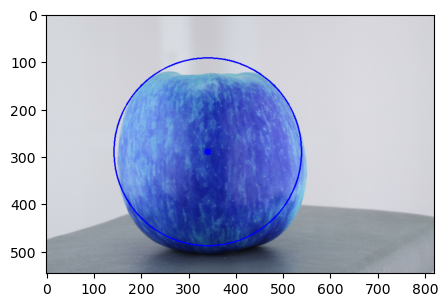

In [133]:
def circle_Hough(subimg):## no use
    """ in a computing way
    another way: Circle detection (HoughCircles, refer to Learning OpenCV book)
    """
    gray_img = cv2.cvtColor(subimg, cv2.COLOR_BGR2GRAY)
    bimg = cv2.medianBlur(gray_img, 5)
    # cimg = cv2.cvtColor(bimg, cv2.COLOR_GRAY2BGR)

    width, height = subimg.shape[0], subimg.shape[1]
    maxR = max(width//2, height//2)
    minR = min(width//5, height//5)
    circles = cv2.HoughCircles(bimg,cv2.HOUGH_GRADIENT,1.2,120, 
                               param1=100,param2=30,
                               minRadius=minR, maxRadius=maxR)
    circles = np.uint16(np.around(circles))

    def circle_detection(circles):
        "detect all the circles, plot circles + centers"
        print(circles, circles[0], circles[0,0])
        for i in circles[0,:]:
            # draw the outer circle
            print(i, i[0], i[1], i[2])
            cv2.circle(subimg,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(subimg,(i[0],i[1]),2,(0,0,255),3)

    # circle_detection(circles)
    # cv2.imshow("Contours",subimg)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    centroid = np.array([subimg.shape[0]//2, subimg.shape[1]//2])
    dist = np.sqrt((subimg.shape[0])**2 + (subimg.shape[1])**2)
    index = 0
    for i, c in enumerate(circles[0,:]):
        d = np.linalg.norm(np.array([c[0], c[1]])-centroid)
        # print(i, d)
        if d < dist:
            dist = d
            index = i

    circle = circles[0][index]
    print(index, circle)
    center, radius = circle[:2], circle[2]

    # draw the outer circle
    cv2.circle(subimg,center,radius,(0,0,255),2)
    # draw the center of the circle
    cv2.circle(subimg,center,2,(0,0,255),10)
    # print(circle[0],circle[1])
    
    plt.figure(figsize = (5,5))
    plt.imshow(subimg)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return center, radius

circle_Hough(img)

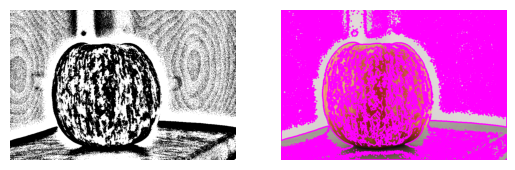

In [144]:
def circle_contour(subimg): ## no use
    "from 03_06_compute_contour.py, 03_07_contour_centroid.py"
    gray_img = cv2.cvtColor(subimg, cv2.COLOR_BGR2GRAY)
    ## another way: build Gaussian threshold (refer 03_06.py)
    thresh = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img2 = subimg.copy()
    index = -1
    thickness = 4
    color = (255, 0, 255)
    cv2.drawContours(img2, contours, index, color, thickness)

    fig, axs = plt.subplots(1,2)
    axs[0].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    plt.show()
    
    #return center, radius
    
circle_contour(img)

In [135]:
def circle_moment(subimg): ## no use
    """https://towardsdatascience.com/computer-vision-for-beginners-part-4-64a8d9856208
    We can find the centroid of an image or calculate the area of a boundary field with the help of the notion called image moment. 
    What does a moment mean here? 
    The word ‘moment’ is a short period of time in common usage. 
    But in physics terminology, a moment is the product of the distance and another physical quantity meaning how a physical quantity is distributed or located. 
    So in computer vision, Image moment is how image pixel intensities are distributed according to their location. 
    It’s a weighted average of image pixel intensities and we can get the centroid or spatial information from the image moment.
    """
    gray_img = cv2.cvtColor(subimg, cv2.COLOR_BGR2GRAY)
    ## convert the grayscale image to binary image
    ret,thresh = cv2.threshold(gray_img,127,255,0)
    ## calculate moments of binary image
    M = cv2.moments(thresh)

    ## calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    radius = 15
    cv2.circle(subimg, (cX, cY), radius, (255, 255, 255), -1)
    if 0:
        """
        Draw the circle on the image using OpenCV's circle function
        center: the center coordinates of the circle
        radius: the radius of the circle
        color: the color of the circle
        thickness: the thickness of the circle outline (set to 2 in this example)
        """
        # draw the center of the circle
        cv2.circle(subimg,center,2,(0,0,255),10)

        cv2.imshow("Moment",subimg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        "Display the image with the drawn circle using matplotlib"
        cv2.putText(subimg, "centroid", (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        plt.imshow(subimg)
        
    return (cX, cY), radius

#circle_moment(img)
        

In [136]:
def circle_blob(subimg):## no use
    "https://learnopencv.com/blob-detection-using-opencv-python-c/"
    "note suitable for multi-small circles, since blob=ban dian in Chinese"

    # Read image
    ##im = cv2.imread(name, cv2.IMREAD_GRAYSCALE)

    subimg = cv2.cvtColor(subimg, cv2.COLOR_BGR2GRAY)

    def parameter():
        # Setup SimpleBlobDetector parameters.
        params = cv2.SimpleBlobDetector_Params()
        
        # Change thresholds
        params.minThreshold = 10
        params.maxThreshold = 200
        
        # Filter by Area.
        params.filterByArea = True
        params.minArea = 100
        params.maxArea = 1000
        
        # Filter by Circularity
        params.filterByCircularity = True
        params.minCircularity = 0.1
        params.maxCircularity = 1
        
        # Filter by Convexity
        params.filterByConvexity = True
        params.minConvexity = 0.87
        params.maxConvexity = 1
        
        # Filter by Inertia
        params.filterByInertia = True
        params.minInertiaRatio = 0.1
        params.maxInertiaRatio = 1

        return params
    
    # Set up the detector with default parameters.
    params = parameter()
    # Create a detector with the parameters
    ver = (cv2.__version__).split('.')
    print(int(ver[0]))
    if int(ver[0]) < 3 :
        detector = cv2.SimpleBlobDetector(params)
    else : 
        detector = cv2.SimpleBlobDetector_create(params)
    
    if 1: 
        # Detect blobs.
        keypoints = detector.detect(subimg)
    else:
        # Apply Laplacian of Gaussian
        blobs_log = cv2.Laplacian(subimg, cv2.CV_64F)
        blobs_log = np.uint8(np.absolute(blobs_log))
        keypoints = detector.detect(blobs_log)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(subimg, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Show keypoints
    if True:
        plt.imshow("Keypoints", im_with_keypoints)
    else:
        cv2.imshow("Keypoints", im_with_keypoints)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [100]:
def circle_match(path, subimg): ## no use
    gray_img = cv2.cvtColor(subimg, cv2.COLOR_BGR2GRAY)
    ## another way: mathTemplate (refer 04_03.py), collapse to work
    template = cv2.imread(path+'ball_template.jpg',0)

    cv2.imshow("Frame",subimg)
    cv2.imshow("Template",template)

    result = cv2.matchTemplate(subimg, template, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    print(max_val,max_loc)
    cv2.circle(result,max_loc, 15,255,2)
    cv2.imshow("Matching",result)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

if 0:
    center, radius = circle_canny(subimg)
else:
    "use above function to get a constant circle of the first photo"
    center, radius = np.array([244, 294]), 212
    
    # draw the outer circle
    cv2.circle(subimg,center,radius,(0,0,255),2)
    # draw the center of the circle
    cv2.circle(subimg,center,2,(0,0,255),10)
    # print(circle[0],circle[1])

    cv2.imshow("Contours",subimg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Compute sphere image information
Suppose it's a unit sphere. 
1. Given tilt-angle $\theta$ of the carema,  photos numbers $n$ 
2. Then computing big-circular-disk $D$ from the carema view, top-cusp-angle $\alpha=2\pi/n$ of the spherical patch $S$. Except the cusp point of $S$, the left can be parametrized by a regular mesh $M$. 
3. Project $M$ into $D$, corresponding planar patch $M_{2D}$ is the one that need to be chosen on every photo.
4. Smoothly transform the planar patch $M_{2D}$ into a rectangular patch $M_{rec}$, then neighbouring patches should smoothly transformed along the two rectangular straight lines.
5. Stitch the rectangular pathes together into 1 image.

In [34]:
### Set given angle and photo numbers
theta, n = (180-150.4)/180*np.pi, 8
alpha = 2*np.pi / n

In [35]:
### Read TOP, Bottom, Left-polyline-pts coodinate
import csv 

def read_csv(name):
    arrays = []
    with open(path0+name, 'r') as f:
        reader = csv.reader(f, delimiter=',') 
        for row in reader: 
            # print(row, len(row))
            row = str(row).replace(';', '')
            row = str(row).replace('[', '')
            row = str(row).replace(']', '')
            row = str(row).replace('\'', '')
            row = str(row).replace('\'', '')
            # print(row, type(row))
            if row =='Pi':
                row = str(np.pi)
            if row =='1.5 * Pi':
                row = str(1.5*np.pi)
            if row =='0.5 * Pi':
                row = str(0.5*np.pi)
            arrays.append(row)

    #print(arrays)
    arr = np.array(arrays[5:])
    phi = np.array([],dtype=float)
    for p in arr:
        phi = np.r_[phi, float(p)]
    print(name, phi.shape)
    return phi

phi_bottom = read_csv('\\phi_bottom.csv') + np.pi/2
phi_left = read_csv('\\phi_left.csv') + np.pi/2
rho_left = read_csv('\\rho_left.csv')


NameError: name 'path0' is not defined

In [36]:
### Plot the polyline
pts_bottom = np.c_[(radius * np.cos(phi_bottom)).astype(int), (radius * np.sin(phi_bottom)).astype(int)]
pts_left = np.c_[(radius * rho_left * np.cos(phi_left)).astype(int), (radius * rho_left * np.sin(phi_left)).astype(int)]
pts_right = np.c_[-pts_left[:,0], pts_left[:,1]]

# bdry_pts = center + np.vstack((pts_bottom[::-1], pts_left, pts_right))

NameError: name 'phi_bottom' is not defined

In [37]:
### Extract the bounded patch
pts1 = (center + pts_left).reshape((-1, 1, 2))
pts2 = (center + pts_bottom).reshape((-1, 1, 2))
pts3 = (center + pts_right).reshape((-1, 1, 2))

isClosed = False
 
# Using cv2.polylines() method, Draw a Blue polygon with thickness of 1 px
ply1 = cv2.polylines(subimg, [pts1], isClosed, (255, 0, 0), thickness=2)
ply2 = cv2.polylines(subimg, [pts2], isClosed, (255, 0, 0), thickness=2)
ply3 = cv2.polylines(subimg, [pts3], isClosed, (255, 0, 0), thickness=2)
# Displaying the image
  
cv2.imshow(name, ply1)
cv2.imshow(name, ply2)
cv2.imshow(name, ply3)
cv2.waitKey()
cv2.destroyAllWindows()

NameError: name 'pts_left' is not defined

In [38]:
### Extract cropped patch:

def crop_image(img, pts):
    # pts = np.array([[[10,150],[150,100],[300,150],[350,100],[310,20],[35,10]]])

    ## (1) Crop the bounding rectangular patch
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    cropped = img[y:y+h, x:x+w].copy()

    ## (2) make mask
    pts = pts - pts.min(axis=0)

    mask = np.zeros(cropped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(cropped, cropped, mask=mask)

    ## (4) add the white background
    bg = np.ones_like(cropped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst

    cv2.imshow("cropped" , cropped)
    cv2.imshow("white background" , dst2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


phi_bdry = read_csv('\\phi_bdry.csv') + np.pi/2
rho_bdry = read_csv('\\rho_bdry.csv')

pts_bdry = np.c_[(radius * rho_bdry * np.cos(phi_bdry)).astype(int), (radius * rho_bdry * np.sin(phi_bdry)).astype(int)]

pts_bdry = (center + pts_bdry).reshape((-1, 1, 2))

crop_image(subimg, pts_bdry)

NameError: name 'path0' is not defined

In [39]:
## no use now; only for test
## Transform the extracted patch into a regular rectangular patch
def warp_extracted_patch(subimg, pt_A, pt_B, pt_C, pt_D):
    # Create a copy of the image
    img_copy = np.copy(subimg)
    img_copy = cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)

    # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))

    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, maxHeight - 1],
                            [maxWidth - 1, maxHeight - 1],
                            [maxWidth - 1, 0]])

    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(subimg,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

    cv2.imshow("Transformed patch" , out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def get_pt(phi, rho, radius, center):
    phi += np.pi/2
    x = (radius * rho * np.cos(phi)).astype(int)
    y = (radius * rho * np.sin(phi)).astype(int)
    return np.array([x, y]) + center

# pt_A = get_pt(5.320, 0.303, radius, center)
# pt_B = get_pt(5.728,0.240, radius, center)
# pt_C = get_pt(5.623,0.194, radius, center)
# pt_D = get_pt(5.200, 0.265, radius, center)

# warp_extracted_patch(subimg, pt_A, pt_B, pt_C, pt_D)

In [ ]:
### Read the 5 lists of points of the extracted patch
def get_list_of_pts(phi, rho, radius, center):
    x = (radius * rho * np.cos(phi)).astype(int)
    y = (radius * rho * np.sin(phi)).astype(int)
    return np.c_[x, y] + center

phi = read_csv('\\patch_list1_phi.csv') + np.pi/2
rho = read_csv('\\patch_list1_r.csv')
pts_list1 = get_list_of_pts(phi, rho, radius, center)

phi = read_csv('\\patch_list2_phi.csv') + np.pi/2
rho = read_csv('\\patch_list2_r.csv')
pts_list2 = get_list_of_pts(phi, rho, radius, center)

phi = read_csv('\\patch_list3_phi.csv') + np.pi/2
rho = read_csv('\\patch_list3_r.csv')
pts_list3 = get_list_of_pts(phi, rho, radius, center)

phi = read_csv('\\patch_list4_phi.csv') + np.pi/2
rho = read_csv('\\patch_list4_r.csv')
pts_list4 = get_list_of_pts(phi, rho, radius, center)

phi = read_csv('\\patch_list5_phi.csv') + np.pi/2
rho = read_csv('\\patch_list5_r.csv')
pts_list5 = get_list_of_pts(phi, rho, radius, center)

num = len(pts_list1)
mid_ind = int(num/2)
width1 = np.linalg.norm(pts_list2[mid_ind]-pts_list1[mid_ind])
width2 = np.linalg.norm(pts_list3[mid_ind]-pts_list2[mid_ind])
width3 = np.linalg.norm(pts_list4[mid_ind]-pts_list3[mid_ind])
width4 = np.linalg.norm(pts_list5[mid_ind]-pts_list4[mid_ind])
width = int((width1+width2+width3+width4)/4)

hgt1 = np.linalg.norm(pts_list1[1:]- pts_list1[:-1], axis=1)
hgt2 = np.linalg.norm(pts_list2[1:]- pts_list2[:-1], axis=1)
hgt3 = np.linalg.norm(pts_list3[1:]- pts_list3[:-1], axis=1)
hgt4 = np.linalg.norm(pts_list4[1:]- pts_list4[:-1], axis=1)
hgt5 = np.linalg.norm(pts_list5[1:]- pts_list5[:-1], axis=1)
height = int(np.mean((hgt1+hgt2+hgt3+hgt4+hgt5)/5))
print(width, height)


In [ ]:
### Merge pieces of rectangular patches together to form 1 big rectangular patch

output_pts = np.float32([[0, 0],
                        [0, height - 1],
                        [width - 1, height - 1],
                        [width - 1, 0]])

def strip(ptlist1, ptlist2):
    # Compute the perspective transform M
    Alist, Blist = ptlist1[1:][::-1], ptlist1[:-1][::-1] ## from the top, left-two
    Dlist, Clist = ptlist2[1:][::-1], ptlist2[:-1][::-1] ## from the top, right-two

    for i in range(1):
        pt_A, pt_B = Alist[i], Blist[i]
        pt_C, pt_D = Clist[i], Dlist[i]
        input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])   
        M = cv2.getPerspectiveTransform(input_pts,output_pts)
        out = cv2.warpPerspective(subimg,M,(width, height),flags=cv2.INTER_LINEAR)

    for i in np.arange(num-2)+1:
        pt_A, pt_B = Alist[i], Blist[i]
        pt_C, pt_D = Clist[i], Dlist[i]
        input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])   
        M = cv2.getPerspectiveTransform(input_pts,output_pts)
        out2 = cv2.warpPerspective(subimg,M,(width, height),flags=cv2.INTER_LINEAR)
        out = cv2.vconcat([out, out2])
    
    return out

s1 = strip(pts_list1, pts_list2)
s2 = strip(pts_list2, pts_list3)
s3 = strip(pts_list3, pts_list4)
s4 = strip(pts_list4, pts_list5)

patch_fliped = cv2.hconcat([s1,s2,s3,s4])
patch = cv2.flip(patch_fliped, 1)

cv2.imshow("Rectangular Patch" , patch)
cv2.waitKey(0)
cv2.destroyAllWindows()